# L4: Word embeddings

In this lab you will explore word embeddings. A **word embedding** is a mapping of words to points in a vector space such that nearby words (points) are similar in terms of their distributional properties. You will use word embedding to find similar words, and evaluate their usefulness in an inference task.

You will use the word vectors that come with [spaCy](http://spacy.io). Note that you will need the &lsquo;large&rsquo; English language model; the &lsquo;small&rsquo; model that you used in previous labs does not include proper word vectors.

In [1]:
import spacy

nlp = spacy.load("en_core_web_lg")

Every word in the model&rsquo;s vocabulary comes with a 300-dimensional vector, represented as a NumPy array. The following code cell shows how to access the vector for the word *cheese*:

In [2]:
#nlp.vocab["cheese"].vector

## Problem 1: Finding similar words

Your first task is to use the word embeddings to find similar words. More specifically, we ask you to write a function `most_similar` that takes a vector $x$ and returns a list with the 10 most similar entries in spaCy&rsquo;s vocabulary, with similarity being defined by cosine.

**Tip:** spaCy already has a [`most_similar`](https://spacy.io/api/vectors#most_similar) method that you can wrap.

In [3]:
# TODO: Enter your implementation of `most_similar` here
import numpy as np

def most_similar(query, n=10):
    query_vec = nlp.vocab[query].vector
    keys = nlp.vocab.vectors.most_similar(np.asarray([query_vec]), n=n)[0][0]
    return [nlp.vocab.strings[k] for k in keys]

Test your implementation by running the following code cell, which will print the 10 most similar words for the word *cheese*:

In [4]:
print(" ".join(w for w in most_similar("cheese")))

Cheese CHEESE cheese Cheddar cheddar CHEDDAR BACON Bacon bacon cheeses


You should get the following output:

Once you have a working implementation of `most_similar`, use it to think about in what sense the returned words really are &lsquo;similar&rsquo; to the cue word. Try to find examples where the cue word and at least one of the words returned by `most_similar` are in the following semantic relations:

1. synonymy (exchangeable meanings)
2. antonymy (opposite meanings)
3. hyperonymy/hyponymy (more specific/less specific meanings)

Document your examples in the code cell below.

In [5]:
# TODO: Insert code here to generate your examples
print(" ".join(w for w in most_similar("dry")))
print(" ".join(w for w in most_similar("hot")))
print(" ".join(w for w in most_similar("cold")))

Dry DRY dry DRYING Drying drying WET Wet wet DAMP
HOT HoT Hot hot SEXY sexy Sexy SIZZLING sizzling Sizzling
cOLD COLD Cold cold chilly Chilly CHILLY WARM warm Warm


## Problem 2: Plotting similar words

Your next task is to visualize the word embedding space by a plot. To do so, you will have to reduce the dimensionality of the space from 300 to 2&nbsp;dimensions. One suitable algorithm for this is [T-distributed Stochastic Neighbor Embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (TSNE), which is implemented in scikit-learn&rsquo;s [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) class.

Write a function `plot_most_similar` that takes a list of words (lexemes) and does the following:

1. For each word in the list, find the most similar words (lexemes) in the spaCy vocabulary.
2. Compute the TSNE transformation of the corresponding vectors to 2&nbsp;dimensions.
3. Produce a scatter plot of the transformed vectors, with the vectors as points and the corresponding word forms as labels.

In [6]:
# TODO: Write code here to plot the most similar words
%matplotlib inline

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_most_similar(word, k=10):
    ms_words = np.array([most_similar(w, k) for w in word]).reshape(len(word)*k)
    ms_vectors = np.array([nlp.vocab[str(word)].vector for word in ms_words])
    y_trans = TSNE(n_components=2).fit_transform(ms_vectors)
    df_one = y_trans[:, 0]
    df_two = y_trans[:, 1]
    plt.scatter(df_one,df_two)
    for index, value in enumerate(ms_words):
        plt.annotate(value, (df_one[index], df_two[index]))

    plt.show()

Test your code by running the following cell:

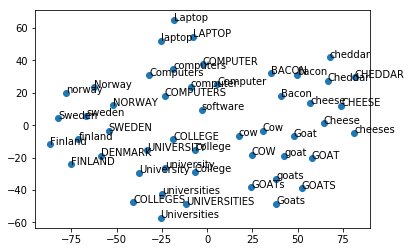

In [7]:
plot_most_similar(["cheese", "goat", "sweden", "university", "computer"])

## Problem 3: Analogies

In a **word analogy task** you are given three words $x$, $y$, $z$ and have to predict a word $w$ that has the same semantic relation to $z$ as $y$ has to $x$. One example is *man*, *woman*, *brother*, the expected answer being *sister* (the semantic relation is *male*/*female*).

[Mikolov et al. (2013)](http://www.aclweb.org/anthology/N13-1090) have shown that word analogy tasks can be solved by adding and substracting word vectors in a word embedding: the vector for *sister* is the closest vector (in terms of cosine distance) to the vector *brother* $-$ *man* $+$ *woman*. Your next task is to write a function `fourth` that takes in three words (say *brother*, *man*, *woman*) and predicts the word that completes the analogy (in this case, *sister*).

In [8]:
def fourth(x,y,z):
    new_eq = nlp.vocab[x].vector.reshape(1, 300) - nlp.vocab[y].vector.reshape(1, 300) + nlp.vocab[z].vector.reshape(1, 300)
    most_similar = nlp.vocab.vectors.most_similar(new_eq)[0][0]
    return nlp.vocab.strings[most_similar[0]]

In [9]:
# TODO: Enter code here to solve the analogy problem
fourth("brother", "man", "woman")

'SISTER'

Test your code by running the following code. You should get *sister*.

In [10]:
print(fourth("Stockholm", "Sweden", "Germany"))
print(fourth("Swedish", "Sweden", "France"))
print(fourth("better", "good", "bad"))
print(fourth("walked", "walk", "take"))

BERLIN
FRENCH
WORSE
TOOK


You should also be able to get the following:

* *Stockholm* $-$ *Sweden* $+$ *Germany* $=$ *Berlin*
* *Swedish* $-$ *Sweden* $+$ *France* $=$ *French*
* *better* $-$ *good* $+$ *bad* $=$ *worse*
* *walked* $-$ *walk* $+$ *take* $=$ *took*

Experiment with other examples to see whether you get the expected output. Provide three examples of analogies for which the model produces the &lsquo;correct&rsquo; answer, and three examples on which the model &lsquo;failed&rsquo;. Based on your theoretical understanding of word embeddings, do you have a hypothesis as to why the model succeeds/fails in completing the analogy? Discuss this question in a short text.

*TODO: Insert your examples and your discussion here*

## Natural language inference dataset

In the second part of this lab, you will be evaluating the usefulness of word embeddings in the context of a natural language inference task. The data for this part is the [SNLI corpus](https://nlp.stanford.edu/projects/snli/), a collection of 570k human-written English image caption pairs manually labeled with the labels *Entailment*, *Contradiction*, and *Neutral*. Consider the following sentence pair as an example:

* Sentence 1: A soccer game with multiple males playing.
* Sentence 2: Some men are playing a sport.

This pair is labeled with *Entailment*, because sentence&nbsp;2 is logically entailed (implied) by sentence&nbsp;1 – if sentence&nbsp;1 is true, then sentence&nbsp;2 is true, too. The following sentence pair, on the other hand, is labeled with *Contradiction*, because both sentences cannot be true at the same time.

* Sentence 1: A black race car starts up in front of a crowd of people.
* Sentence 2: A man is driving down a lonely road.

For detailed information about the corpus, refer to [Bowman et al. (2015)](https://www.aclweb.org/anthology/D15-1075/). For this lab, we load the training portion and the development portion of the dataset.

**Note:** Because the SNLI corpus is rather big, we initially only load a small portion (25,000 samples) of the training data. Once you have working code for Problems&nbsp;4–6, you should set the flag `final` to `True` and re-run all cells with the full dataset.

In [11]:
import bz2
import pandas as pd

final_evaluation = True    # TODO: Set to True for the final evaluation!

with bz2.open("../input/train.jsonl.bz2", 'rt') as source:
    if final_evaluation:
        df_train = pd.read_json(source, lines=True)
    else:
        df_train = pd.read_json(source, lines=True)[:25000]
    print("Number of sentence pairs in the training data:", len(df_train))

with bz2.open("../input/dev.jsonl.bz2", 'rt') as source:
    df_dev = pd.read_json(source, lines=True)
    print("Number of sentence pairs in the development data:", len(df_dev))

Number of sentence pairs in the training data: 549367
Number of sentence pairs in the development data: 9842


When you inspect the data frames, you will see that we have preprocessed the sentences and separated tokens by spaces. In the columns `tagged1` and `tagged2`, we have added the part-of-speech tags for every token (as predicted by spaCy), also separated by spaces.

In [12]:
df_train.head()

,gold_label,sentence1,tags1,sentence2,tags2
0,neutral,A person on a horse jumps over a broken down a...,DET NOUN ADP DET NOUN VERB ADP DET ADJ ADP NOU...,A person is training his horse for a competiti...,DET NOUN AUX VERB PRON NOUN ADP DET NOUN PUNCT
1,contradiction,A person on a horse jumps over a broken down a...,DET NOUN ADP DET NOUN VERB ADP DET ADJ ADP NOU...,"A person is at a diner , ordering an omelette .",DET NOUN AUX ADP DET NOUN PUNCT VERB DET NOUN ...
2,entailment,A person on a horse jumps over a broken down a...,DET NOUN ADP DET NOUN VERB ADP DET ADJ ADP NOU...,"A person is outdoors , on a horse .",DET NOUN AUX ADV PUNCT ADP DET NOUN PUNCT
3,neutral,Children smiling and waving at camera,NOUN VERB CCONJ VERB ADP NOUN,They are smiling at their parents,PRON AUX VERB ADP PRON NOUN
4,entailment,Children smiling and waving at camera,NOUN VERB CCONJ VERB ADP NOUN,There are children present,PRON AUX NOUN ADJ


## Problem 4: Two simple baselines

Your first task is to establish two simple baselines for the natural language inference task.

### Random baseline

One drawback with the Most Frequent Class (MFC) baseline is that it does not yield well-defined precision and recall values for all classes. Here we therefore ask you to implement a classifier that generates *random* predictions, where the probability of a class is determined by its relative frequency in the training data. This functionality is provided by scikit-learn&rsquo;s [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). Write code to evaluate the performance of this classifier on the development data.

In [13]:
# TODO: Enter code here to implement the random baseline. Print the classification report.
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

dummy_clf = DummyClassifier(strategy='stratified', random_state=0)
dummy_clf.fit(df_train["sentence1"], df_train["gold_label"])
dummy_pred = dummy_clf.predict(df_dev["sentence2"])
print(classification_report(df_dev["gold_label"], dummy_pred))

               precision    recall  f1-score   support

contradiction       0.34      0.33      0.34      3278
   entailment       0.33      0.34      0.34      3329
      neutral       0.32      0.32      0.32      3235

     accuracy                           0.33      9842
    macro avg       0.33      0.33      0.33      9842
 weighted avg       0.33      0.33      0.33      9842



In [14]:
accuracy_score(df_dev["gold_label"], dummy_pred)

0.33052225157488313

### One-sided baseline

A second obvious baseline for the inference task is to predict the class label of a sentence pair based on the text of only one of the two sentences, just as in a standard document classification task. Put together a simple [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) + [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) pipeline that implements this idea, train it, and evaluate it on the development data. Is it better to base predictions on sentence&nbsp;1 or sentence&nbsp;2?

In [15]:
# TODO: Enter code here to implement the one-sentence baselines. Print the classification reports.
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

logisReg_clf = Pipeline(
        steps=[('vector', CountVectorizer()),
               ('clf', LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000,random_state=1234))])
               
logisReg_clf.fit(df_train["sentence2"], df_train["gold_label"])
y_pred = logisReg_clf.predict(df_dev["sentence2"])
y_true = df_dev["gold_label"]
print(classification_report(y_true, y_pred))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


               precision    recall  f1-score   support

contradiction       0.65      0.63      0.64      3278
   entailment       0.64      0.72      0.68      3329
      neutral       0.67      0.60      0.63      3235

     accuracy                           0.65      9842
    macro avg       0.65      0.65      0.65      9842
 weighted avg       0.65      0.65      0.65      9842



In [16]:
accuracy_score(y_true, y_pred)

0.6504775452143873

Answer> Sentence 2 had better base prediction.

Smaller Dataset  One sided Baseline: 60.20

## Problem 5: A classifier based on manually engineered features

[Bowman et al., 2015](https://www.aclweb.org/anthology/D15-1075/) evaluate a classifier that uses (among others) **cross-unigram features**. This term is used to refer to pairs of unigrams $(w_1, w_2)$ such that $w_1$ occurs in sentence&nbsp;1, $w_2$ occurs in sentence&nbsp;2, and both have been assigned the same part-of-speech tag.

Your next task is to implement the cross-unigram classifier. To this end, the next cell contains skeleton code for a transformer that you can use as the first component in a classification pipeline. This transformer converts each row of the SNLI data frame into a space-separated string consisting of

* the standard unigrams (of sentence&nbsp;1 or sentence&nbsp;2 – this depends on your results in Problem&nbsp;4)
* the cross-unigrams, as defined above.

The space-separated string forms a new &lsquo;document&rsquo; that can be passed to a vectorizer in exactly the same way as a standard sentence in Problem&nbsp;4.

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
from itertools import chain, product

class CrossUnigramsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def bagit(post, sent):
        postDict = {}
        for i, j in zip(post, sent):
            if i == "PUNCT":
                continue
            try:
                postDict[i].append(j)
            except:
                postDict[i] = []
                postDict[i].append(j)
        return postDict
    
    def getCrossUniGrams(pd1, pd2):
        cug = []
        keys = set(pd1.keys()).intersection(set(pd2.keys()))
        for k in keys:
            l1 = pd1[k]
            l2 = pd2[k]
            for w1 in l1:
                for w2 in l2:
                    cug.append(w1+w2)
        return cug

    # Vectorize a sentence-tag-sentence-tag quadruple.
    def _transform(self, sentence1, tags1, sentence2, tags2):
        # TODO: Replace the following line with your own code
        bag1 = sentence1.lower().split() 
        bag2 = sentence2.lower().split()
        pd1 = CrossUnigramsTransformer.bagit(tags1.split(), bag1)
        pd2 = CrossUnigramsTransformer.bagit(tags2.split(), bag2)
        crossUniGram = CrossUnigramsTransformer.getCrossUniGrams(pd1, pd2)
        return " ".join(crossUniGram+bag2)

    def transform(self, X):
        return [self._transform(s1, t1, s2, t2) for s1, t1, s2, t2  in X]

Once you have an implementation of the transformer, extend the pipeline that you built for Problem&nbsp;4, train it, and evaluate it on the development data.

In [18]:
# TODO: Enter code here to implement the cross-unigrams classifier. Print the classification report.
gram_clf = Pipeline([
        ('unigram', CrossUnigramsTransformer()),
        ('vector', CountVectorizer()),
        ('clf', LogisticRegression(solver='saga', multi_class='multinomial', max_iter=1000, random_state=1234))])

gram_clf.fit(df_train.iloc[:,1:5].values, df_train["gold_label"])
predicted_cross = gram_clf.predict(df_dev.iloc[:,1:5].values) 
print(classification_report(y_true = df_dev["gold_label"], y_pred = predicted_cross))
print(accuracy_score(y_true = df_dev["gold_label"], y_pred = predicted_cross))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


               precision    recall  f1-score   support

contradiction       0.78      0.77      0.78      3278
   entailment       0.76      0.81      0.78      3329
      neutral       0.73      0.69      0.71      3235

     accuracy                           0.76      9842
    macro avg       0.76      0.76      0.76      9842
 weighted avg       0.76      0.76      0.76      9842

0.7566551513919935


Smaller Dataset acc: 66.094

## Problem 6: A classifier based on word embeddings

Your last task in this lab is to build a classifier for the natural language inference task that uses word embeddings. More specifically, we ask you to implement a vectorizer that represents each sentence as the sum of its word vectors – a representation known as the **continuous bag-of-words**. Thus, given that spaCy&rsquo;s word vectors have 300 dimensions, each sentence will be transformed into a 300-dimensional vector. To represent a sentence pair, the vectorizer should concatenate the vectors for the individual sentences; this yields a 600-dimensional vector. This vector can then be passed to a classifier.

The next code cell contains skeleton code for the vectorizer. You will have to implement two methods: one that maps a single sentence to a vector (of length 300), and one that maps a sentence pair to a vector (of length 600).

In [19]:
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin

class PairedSentenceVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    # Vectorize a single sentence.
    def _transform1(self, sentence):
        # TODO: Replace the following line with your own code
        word_vec = np.zeros((1, 300))
        for word in sentence.split(" "):
            word_vec += nlp.vocab[word].vector
        return word_vec

    # Vectorize a pair of sentences.
    def _transform2(self, sentence1, sentence2):
        # TODO: Replace the following line with your own code
        sv1 = self._transform1(sentence1)
        sv2 = self._transform1(sentence2)
        return np.concatenate((sv1, sv2), axis=1)

    def transform(self, X):
        return np.concatenate(
            [self._transform2(s1, s2).reshape(1, -1) for s1, t1, s2, t2 in X]
        )

Once you have a working implementation, build a pipeline consisting of the new vectorizer and a [multi-layer perceptron classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). This more powerful (compared to logistic regression) classifier is called for here because we do not specify features by hand (as we did in Problem&nbsp;5), but want to let the model learn a good representation of the data by itself. Use 3&nbsp;hidden layers, each with size 300. It suffices to train the classifier for 8&nbsp;iterations (epochs).

In [20]:
# TODO: Enter code here to implement the word embeddings classifier. Print the classification report.
from sklearn.neural_network import MLPClassifier

gram_clf = Pipeline([
        ('vector', PairedSentenceVectorizer()),
        ('clf', MLPClassifier(hidden_layer_sizes=(300, 300, 300), max_iter=8 ))])

gram_clf.fit(df_train.iloc[:,1:5].values, df_train["gold_label"])
predicted_cross = gram_clf.predict(df_dev.iloc[:,1:5].values) 
print(classification_report(y_true = df_dev["gold_label"], y_pred = predicted_cross))
print(accuracy_score(y_true = df_dev["gold_label"], y_pred = predicted_cross))

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


               precision    recall  f1-score   support

contradiction       0.77      0.77      0.77      3278
   entailment       0.79      0.78      0.78      3329
      neutral       0.71      0.73      0.72      3235

     accuracy                           0.76      9842
    macro avg       0.76      0.76      0.76      9842
 weighted avg       0.76      0.76      0.76      9842

0.7580776264986792


Smaller Dataset acc: 64.83

## Final evaluation

Once you have working code for all problems, re-run the code for Problems&nbsp;4–6 with the full training data. What are your results? How do they differ from the results that you obtained for the smaller training data? How do you interpret this? Summarize your findings in a short text.

Answer> The accuracy has increased marginally for all the problems 4 to 6 as we increased the dataset size. Problem 5 and 6 have similar accuracy if 75% on the development dataset. This clearly shows that the classifiers get better as the data increases. 

The final dataset is 20 times larger than the one we previously trained on. I think, icreasing the data further wont make any further difference. To improve the classifier further we will have to tune the parameters for the classifiers and do better with the feature extraction. Increasing the amount of labelled data can only help us improve the classifier to an extent. It stabilizes after a time and wont make significant difference no matter how much we increase the data.

*TODO: Insert your discussion of the experimental results here*

<div class="alert alert-info">
    Please read the section ‘General information’ on the ‘Labs’ page of the course website before submitting this notebook!
</div>